# Mapping atom analysis
Valid for experiments from 2025-04-30 until ...


In [647]:
date_filters = ["2025-06-03"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\11\000026620-GeneralVariableScan_atom_loading_2_scan_over_t_FORT_drop.h5, which is corrupt
found 54 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\07\000026578-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\08\000026579-GeneralVariableScan.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\08\000026579-GeneralVariableScan_microwave_Rabi_2_scan_over_dummy_variable.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\09\000026580-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-03\09\000026580-GeneralVariableScan_microwave_Rabi_2_scan_over_dummy_variable.h5) scanned over dummy_variable
file 5 (C:\Networking 

experiment: atom_loading_2_experiment
override: {'dummy_variable':4,'t_microwave_pulse':4.5*us,'f_microwaves_dds':(334.684101+0.02)*MHz}
# of iterations:  14
center=0.0000, sigma=20000.0000, depth=0.6282


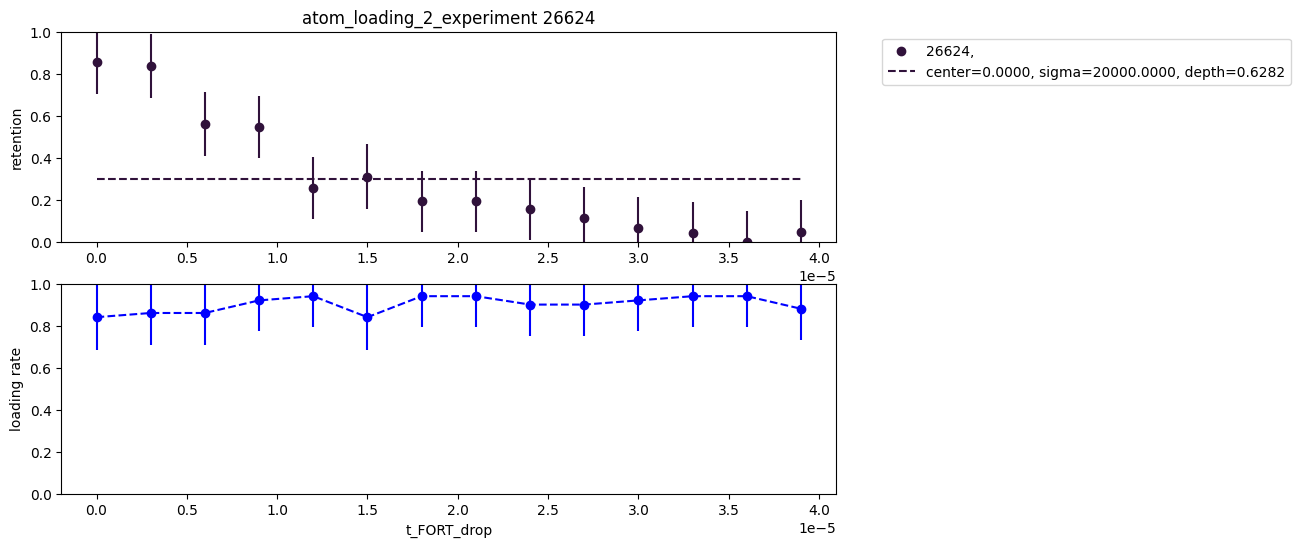

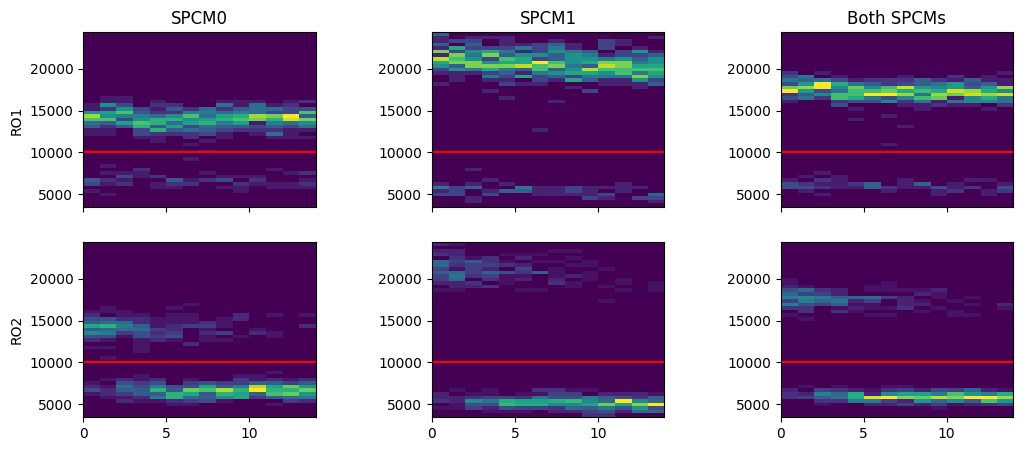

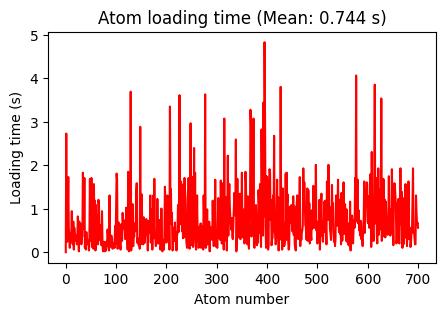

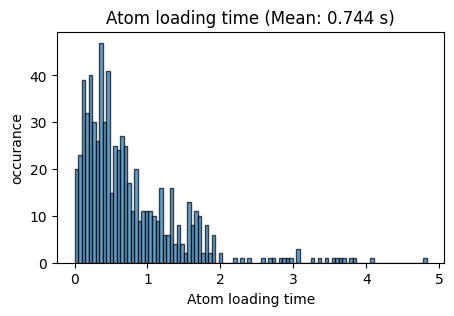

In [648]:
### the file(s) to analyze:
file_indices = {
    52:'',
    # 10:'',
    # 12:'',
    # 191:'',
    # 193:'',
    # 195:'',
    # 197:'',
    # 199:'',
    # 201:'',
    # 203:'',
    # 205:'',
    # 207:'',
    # 209:'',
    # 211:'',
    # 213:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = True

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(10, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}
            min_idx = np.argmin(retention_array)
            initial_center = scan_sequence1[min_idx]
            p0 = [initial_center, 10e3, 0.9] # [center, width, depth]
            
            ### using a  Gaussian function for now:
            fit_dict = {
                scan_variable1_name: {
                    'model': lambda x, center, sigma, depth: 0.80*(1 - depth * np.exp(-((x - center)**2/(2*sigma**2)))),
                    'p0': p0,
                    'bounds': ([min(scan_sequence1), 0, 0], [max(scan_sequence1), np.inf, 1]),
                    'params': ['center', 'sigma', 'depth']
                }
            }

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()

#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.
mean_loading_time = np.mean(Atom_loading_time)  
plt.figure(figsize=(5, 3))
plt.plot(Atom_loading_time, 'r-')

plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(Atom_loading_time, bins=100, edgecolor='black', alpha=0.7)
# plt.plot(Atom_loading_time, 'r-')

plt.xlabel("Atom loading time")
plt.ylabel("occurance")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

In [611]:
AZ_bottom_volts_MOT

7.279

In [612]:
AZ_top_volts_MOT

7.694

In [613]:
AX_volts_MOT

0.115

In [614]:
AY_volts_MOT

-0.291

In [615]:
set_point_PD1_AOM_A1

0.0347

In [616]:
set_point_PD2_AOM_A2

0.0515

In [617]:
set_point_PD3_AOM_A3

0.0332

In [618]:
set_point_PD4_AOM_A4

0.0453

In [619]:
set_point_PD5_AOM_A5

0.0236

In [620]:
set_point_PD6_AOM_A6

0.0381

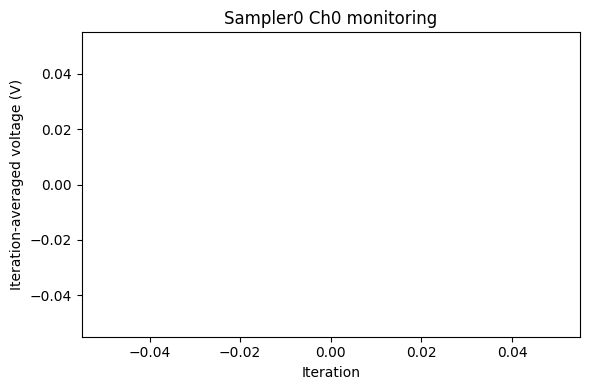

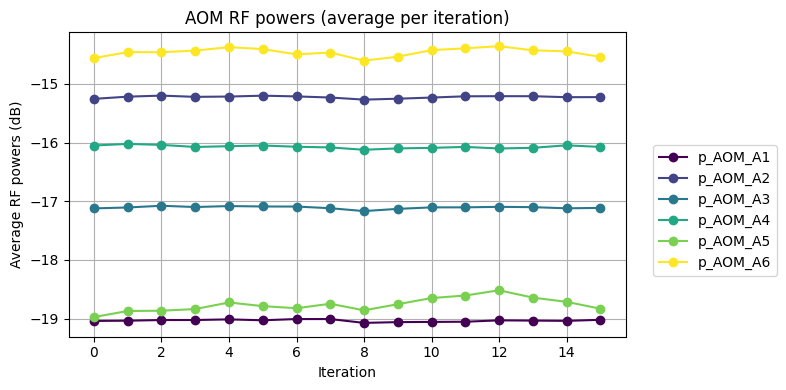

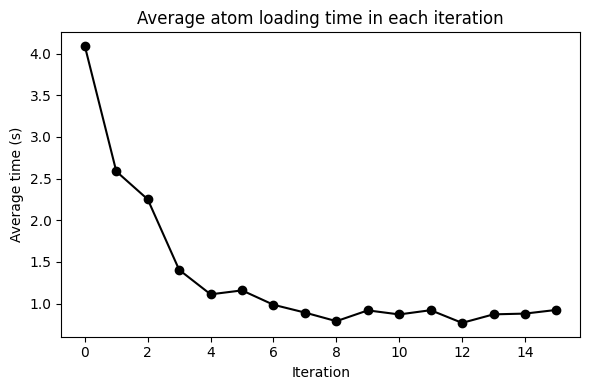

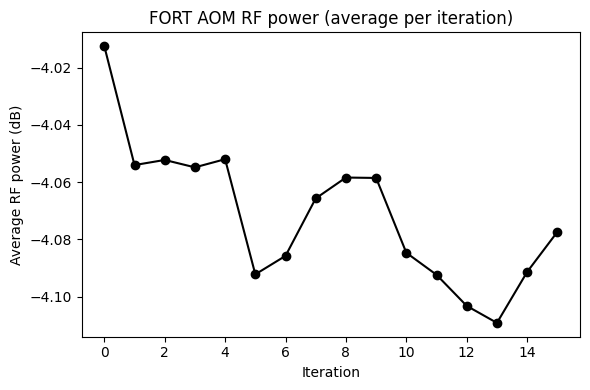

In [623]:
"""
Calculating and plotting the iteration averaged RF powers to the AOMs, along with the atom loading time. This requires n_feedback_per_iteration 
and n_atom_loaded_per_iteration datasets which are generated in some experiments.

The goal is to see if there is any correlation between bad atom loading (averaged over an iteration) and RF values (averaged over an iteration). 
This would indicate a Sampler issue, for example.

n_feedback_per_iteration[1:] = [2,2,3,2,5,...], with len()=iteration, shows the number of times the feedback ran in each iteration. Therefore, it is used to 
splice the RF power arrays, like p_AOM_A1_history, into subarrays for each iteration (first subarray for the first iteration, etc.).
"""

######## Splice the sampler testing array and average over each iteration
Sampler0_ch0_iteration_ave = []
start = 0
for i in range(iterations):
    subset = Sampler0_test[1:][i*n_measurements:(i+1)*n_measurements]
    avg = np.mean(subset)
    Sampler0_ch0_iteration_ave.append(avg)

plt.figure(figsize=(6, 4))
plt.plot(Sampler0_ch0_iteration_ave, marker='o', linestyle='-', color='black')
plt.title('Sampler0 Ch0 monitoring')
plt.xlabel('Iteration')
plt.ylabel('Iteration-averaged voltage (V)')
plt.tight_layout()
plt.show()


### Initialize list of suffixes and colors
channel_suffixes = range(1, 7)
colors = plt.cm.viridis(np.linspace(0, 1, len(channel_suffixes)))

plt.figure(figsize=(8, 4))

##### Loop over each channel to splice p_AOM_Ai_history arrays and average
for i, suffix in enumerate(channel_suffixes):
    var_name = f'p_AOM_A{suffix}_history'
    history = globals()[var_name][1:]  # skip the first element
    n_feedback = n_feedback_per_iteration[1:].astype(int)
    
    ### Compute per-iteration averages
    iteration_averages = []
    start = 0
    for count in n_feedback:
        subset = history[start:start+count]
        avg = np.mean(subset)
        iteration_averages.append(avg)
        start += count
    iteration_averages = np.array(iteration_averages)

    plt.plot(iteration_averages, marker='o', linestyle='-',
             color=colors[i], label=f'p_AOM_A{i+1}')

plt.title('AOM RF powers (average per iteration)')
plt.xlabel('Iteration')
plt.ylabel('Average RF powers (dB)')
plt.legend(loc=(1.05, 0.2))
plt.grid(True)
plt.tight_layout()
plt.show()


##### Splice Atom_loading_time array and average
Atom_loading_time_iteration_ave = []
start = 0
for count in n_atom_loaded_per_iteration[1:].astype(int):
    subset = Atom_loading_time[1:][start:start+count]
    avg = np.mean(subset)
    Atom_loading_time_iteration_ave.append(avg)
    start += count

Atom_loading_time_iteration_ave = np.array(Atom_loading_time_iteration_ave)

plt.figure(figsize=(6, 4))
plt.plot(Atom_loading_time_iteration_ave, marker='o', linestyle='-', color='black')
plt.title('Average atom loading time in each iteration')
plt.xlabel('Iteration')
plt.ylabel('Average time (s)')
plt.tight_layout()
plt.show()


###### Splice p_FORT_loading_history array and average
p_FORT_loading_history_iteration_ave = []
start = 0
for count in n_feedback_per_iteration[1:].astype(int):
    subset = p_FORT_loading_history[1:][start:start+count]
    avg = np.mean(subset)
    p_FORT_loading_history_iteration_ave.append(avg)
    start += count

p_FORT_loading_history_iteration_ave = np.array(p_FORT_loading_history_iteration_ave)

plt.figure(figsize=(6, 4))
plt.plot(p_FORT_loading_history_iteration_ave, marker='o', linestyle='-', color='black')
plt.title('FORT AOM RF power (average per iteration)')
plt.xlabel('Iteration')
plt.ylabel('Average RF power (dB)')
plt.tight_layout()
plt.show()



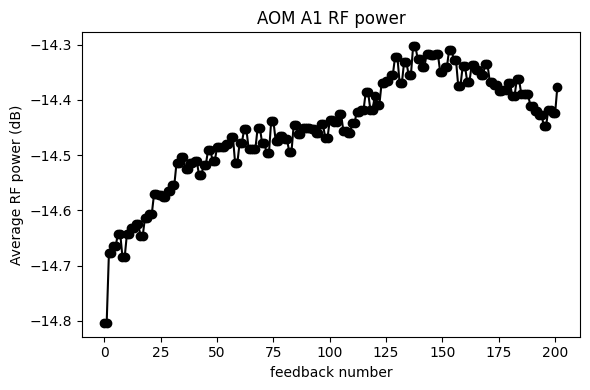

In [282]:
plt.figure(figsize=(6, 4))
plt.plot(p_AOM_A1_history, marker='o', linestyle='-', color='black')
plt.title('AOM A1 RF power')
plt.xlabel('feedback number')
plt.ylabel('Average RF power (dB)')
plt.tight_layout()
plt.show()

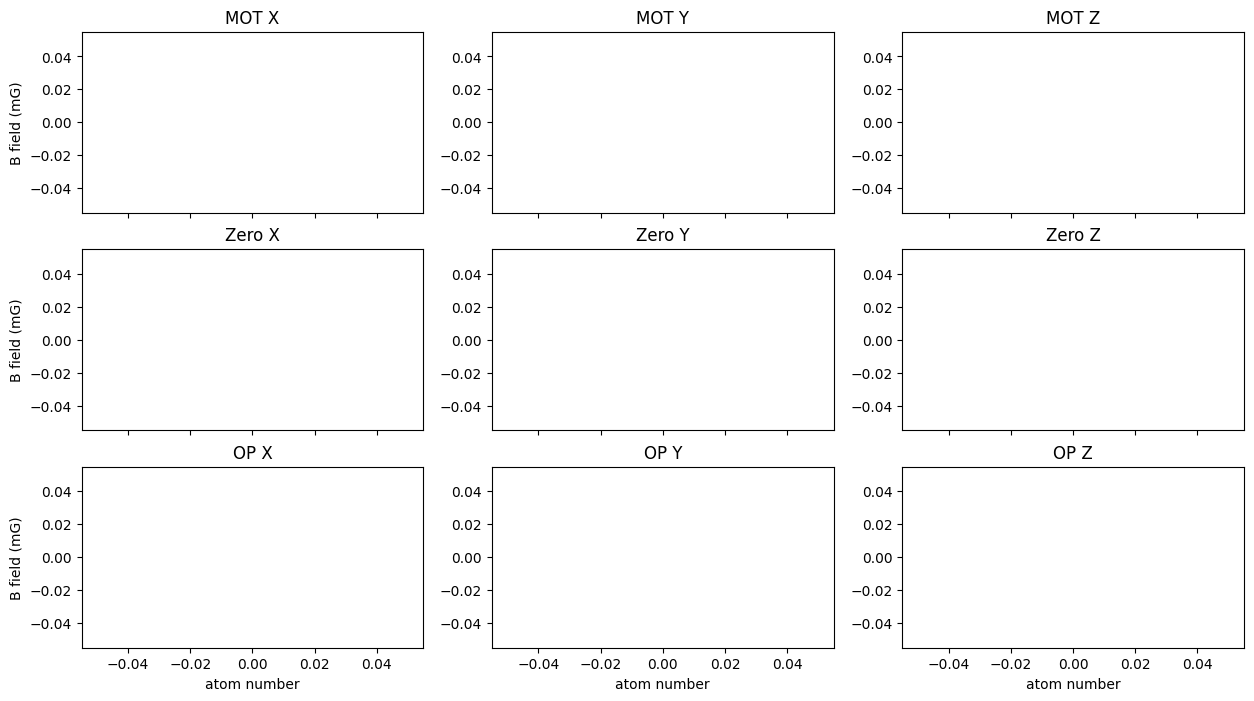

In [588]:
"""
Plotting the magnetometer added to ARTIQ since 2025-04-19.
For all atom loading events. Note that the magneometer is measured in every "measurement", not necessarily when 

"""
fig, axs = plt.subplots(3, 3, figsize=(15, 8), sharey=False, sharex=True)

######## MOT
axs[0, 0].plot(Magnetometer_MOT_X[1:])
axs[0, 0].set_ylabel("B field (mG)")
axs[0, 0].set_title("MOT X")

axs[0, 1].plot(Magnetometer_MOT_Y[1:])
axs[0, 1].set_title("MOT Y")

axs[0, 2].plot(Magnetometer_MOT_Z[1:])
axs[0, 2].set_title("MOT Z");


######## Zero
axs[1, 0].plot(Magnetometer_Zero_X[1:])
axs[1, 0].set_ylabel("B field (mG)")
axs[1, 0].set_title("Zero X")

axs[1, 1].plot(Magnetometer_Zero_Y[1:])
axs[1, 1].set_title("Zero Y")

axs[1, 2].plot(Magnetometer_Zero_Z[1:])
axs[1, 2].set_title("Zero Z");


######## OP
axs[2, 0].plot(Magnetometer_OP_X[1:])
axs[2, 0].set_xlabel("atom number")
axs[2, 0].set_ylabel("B field (mG)")
axs[2, 0].set_title("OP X")

axs[2, 1].plot(Magnetometer_OP_Y[1:])
axs[2, 1].set_xlabel("atom number")
axs[2, 1].set_title("OP Y")

axs[2, 2].plot(Magnetometer_OP_Z[1:])
axs[2, 2].set_xlabel("atom number")
axs[2, 2].set_title("OP Z");





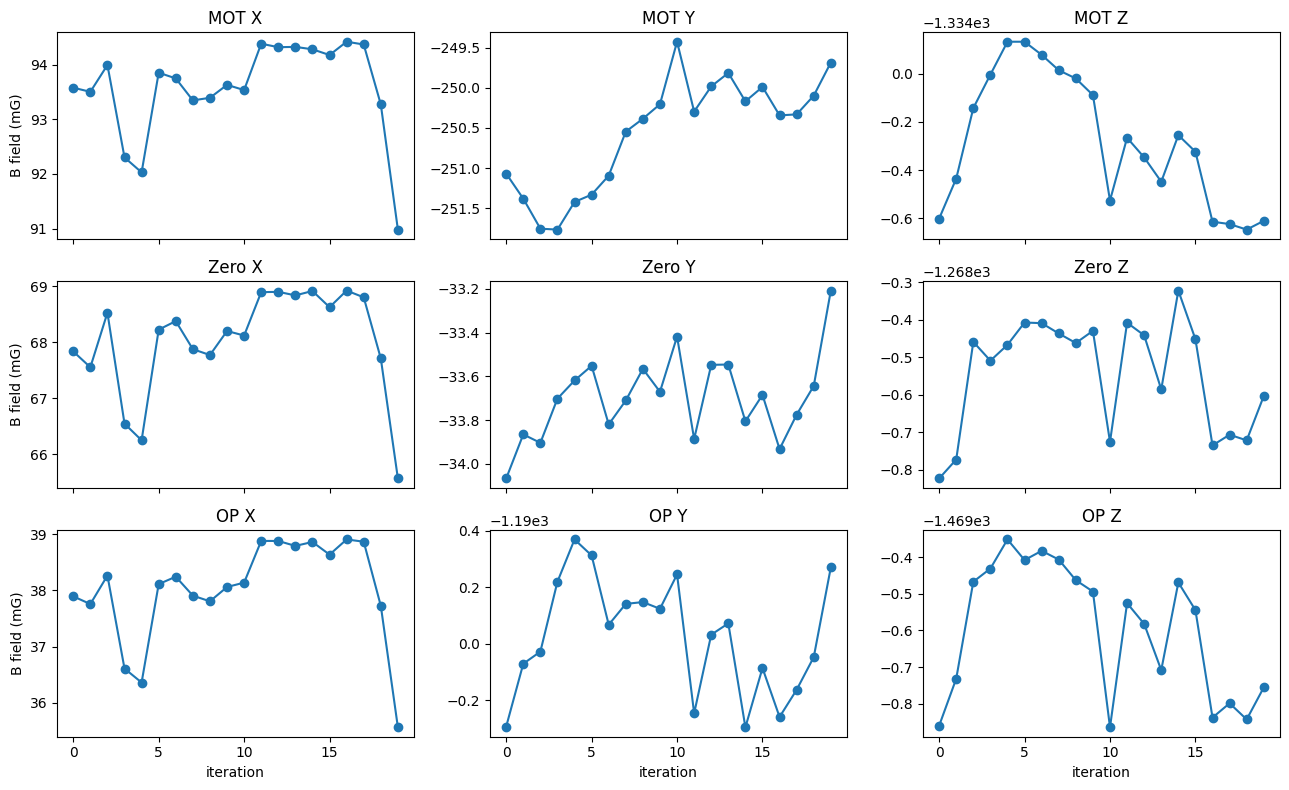

In [432]:
"""
Plotting the magnetometer averaged in each iteration.
For all atom loading events. Note that the magneometer is measured in every "measurement", not necessarily when we load an atom. 

"""

######## Splice the magnetometer data array and average over each iteration
Magnetometer_data = [Magnetometer_MOT_X[1:], Magnetometer_MOT_Y[1:], Magnetometer_MOT_Z[1:], 
                     Magnetometer_Zero_X[1:], Magnetometer_Zero_Y[1:], Magnetometer_Zero_Z[1:],
                     Magnetometer_OP_X[1:], Magnetometer_OP_Y[1:], Magnetometer_OP_Z[1:]]

Magnetometer_data_iteration_ave = [[] for _ in range(len(Magnetometer_data))]

for d in range(len(Magnetometer_data)):
    start = 0
    for i in range(iterations):
        subset = Magnetometer_data[d][i*n_measurements:(i+1)*n_measurements]
        avg = np.mean(subset)
        Magnetometer_data_iteration_ave[d].append(avg)



fig, axs = plt.subplots(3, 3, figsize=(13, 8), sharey=False, sharex=True)
titles = [
    "MOT X", "MOT Y", "MOT Z",
    "Zero X", "Zero Y", "Zero Z",
    "OP X", "OP Y", "OP Z"
]

# ylabels = ["B field (mG)"] * 3 + ["B field (mG)"] * 3 + ["B field (mG)"] * 3
ylabels = ["B field (mG)"] + [""]*2 + ["B field (mG)"] + [""]*2 + ["B field (mG)"] + [""]*2
xlabels = [""] * 6 + ["iteration"] * 3  # Only bottom row gets x-axis labels

for idx, avg_data in enumerate(Magnetometer_data_iteration_ave):
    row = idx // 3
    col = idx % 3
    ax = axs[row, col]
    
    ax.plot(avg_data, marker='o')  # add markers for clarity
    ax.set_title(titles[idx])
    
    if ylabels[idx]:
        ax.set_ylabel(ylabels[idx])
    if xlabels[idx]:
        ax.set_xlabel(xlabels[idx])

plt.tight_layout()
plt.show()


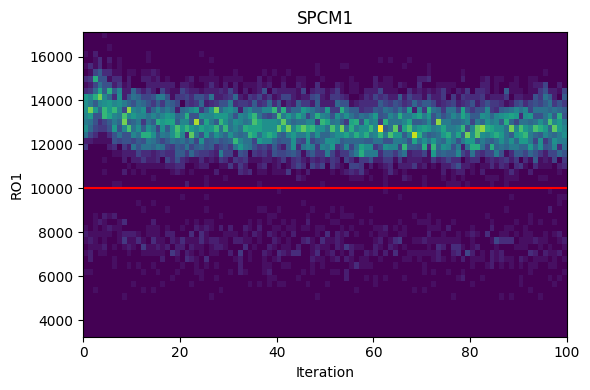

In [195]:
"""
Slicing SPCM1_RO1 into more sections to see the readout fluctuation over time in more details. 

"""

n = 100
ii = 100
SPCM1_RO1_hists = []
SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n:(i+1)*n]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(ii)])

hist_data = np.array(SPCM1_RO1_hists[0]).T  # shape: [bins, ii]

plt.figure(figsize=(6, 4))
plt.imshow(hist_data, origin='lower', extent=[0, ii, histMin, histMax], aspect='auto')

# Add horizontal line at the cutoff
plt.axhline(cutoff1 / t_SPCM_first_shot, color='red')

# Axis labels and title
plt.xlabel("Iteration")
plt.ylabel("RO1")
plt.title("SPCM1")

plt.tight_layout()
plt.show()

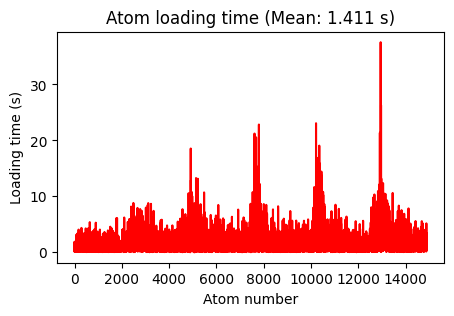

In [638]:
#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.

data = Atom_loading_time[15000:]

mean_loading_time = np.mean(data)  
plt.figure(figsize=(5, 3))
plt.plot(data, 'r-')

plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
plt.show()